In [30]:
from iros.io import fetch_simulation
from iros.mask import fetch_camera, encode, decode, count, _bisect_interval
from iros.images import compose, argmax

from iros.assets import path_wfm_mask

import numpy as np
import matplotlib.pyplot as plt

# PSF Filtering

In [29]:
from functools import partial
from scipy.signal import convolve


PARAMS_PSFY = {
    "center": 0,
    "alpha": 0.3214,
    "beta": 0.6246,
}


def modsech(x, norm, center, alpha, beta):
    return norm / np.cosh(np.abs((x - center) / alpha) * beta)


psfy = partial(modsech, norm=1, **PARAMS_PSFY)


def kernel_filter_psf(camera):
    bins = camera.bins_detector
    min_bin, max_bin = _bisect_interval(np.round(bins.y, 2), -5, +5)
    bin_edges = bins.y[min_bin: max_bin + 1]
    midpoints = (bin_edges[1:] + bin_edges[:-1]) / 2
    kernel = psfy(midpoints).reshape(len(midpoints), -1)
    return kernel / np.sum(kernel)


def filter_psf(camera, shadowgram):
    return convolve(shadowgram, kernel_filter_psf(camera), mode="same")


# Data check

In [47]:
sdl = fetch_simulation("../../simulations/id00/")
wfm = fetch_camera(path_wfm_mask, (5, 8))

detector_1a = count(wfm, sdl.reconstructed["cam1a"])
balanced_1a, var_1a = decode(wfm, detector_1a)

detector_1b = count(wfm, sdl.reconstructed["cam1b"])
balanced_1b, var_1b = decode(wfm, detector_1b)

composed, composed_f = compose(balanced_1a, balanced_1b)
max_composed = argmax(composed)
max_balanced_1a, max_balanced_1b = composed_f(*max_composed)

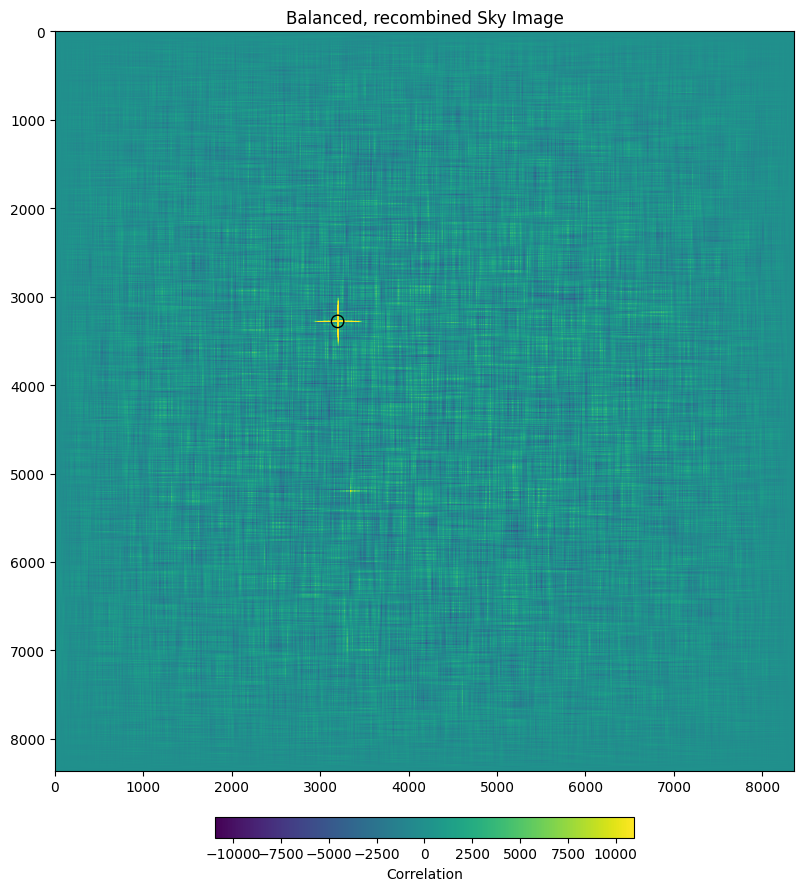

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
c0 = ax.imshow(composed, vmax=-np.min(composed))
ax.scatter(max_composed[1], max_composed[0], s=80, facecolors='none', edgecolors='k')
fig.colorbar(c0, ax=ax, label="Correlation", location="bottom", pad=0.05, shrink=.45)
ax.set_title("Balanced, recombined Sky Image")
plt.show()

# Subtraction

In [49]:
from scipy.ndimage import center_of_mass


def slit_tile(a, i, j, mi=32, mj=5):
    return a[i - mi: i + mi + 1, j - mj: j + mj + 1]

def center_of_gravity(a, i, j, mi=32, mj= 5):
    slit = slit_tile(a, i, j, mi, mj)
    cog_i, cog_j = center_of_mass(slit)
    return i - mi + cog_i, j - mj + cog_j

## No PSF filtering

In [61]:
def subtract(balanced):
    cog = center_of_gravity(balanced, *np.unravel_index(np.argmax(balanced), balanced.shape))

    sky_model = np.zeros(wfm.sky_shape)
    cog_i, cog_j = round(cog[0]), int(cog[1])
    decimal_j = cog[1] - cog_j
    sky_model[cog_i, cog_j] = (1 - decimal_j) * balanced[cog_i, cog_j]
    sky_model[cog_i, cog_j + 1] = decimal_j * balanced[cog_i, cog_j + 1]
    shadowgram = encode(wfm, sky_model) * wfm.bulk
    norm_shadowgram = np.sum(~np.isclose(shadowgram, np.zeros_like(shadowgram)))
    model, _ =  decode(wfm, shadowgram / norm_shadowgram)

    sky_model[cog_i, cog_j] *= (balanced[cog_i, cog_j] / model[cog_i, cog_j])
    sky_model[cog_i, cog_j + 1] *= (balanced[cog_i, cog_j + 1] / model[cog_i, cog_j + 1])
    shadowgram = encode(wfm, sky_model) * wfm.bulk
    model, _ =  decode(wfm, shadowgram / norm_shadowgram)
    return balanced - model, shadowgram / norm_shadowgram

In [62]:
balanced_1a_subtracted, shadowgram_1a = subtract(balanced_1a)

In [63]:
balanced_1b_subtracted, shadowgram_1b = subtract(balanced_1b)

In [64]:
composed_sutracted, composed_f = compose(balanced_1a_subtracted, balanced_1b_subtracted)
max_subtracted = np.unravel_index(np.argmax(composed), composed.shape)

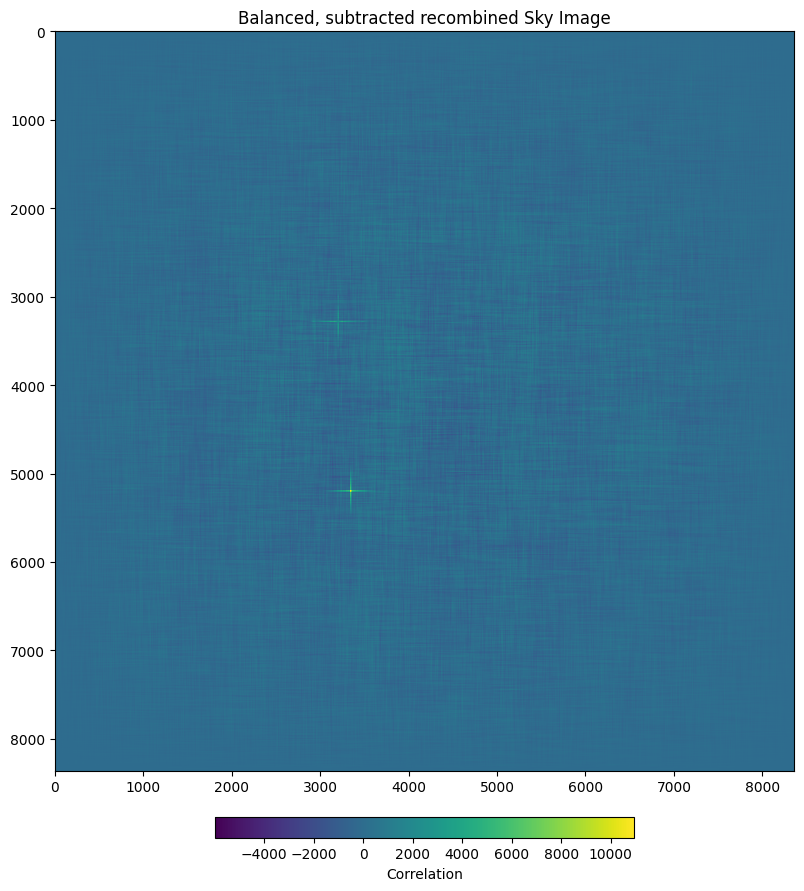

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
c0 = ax.imshow(composed_sutracted, vmax=-np.min(composed))
#ax.scatter(max_subtracted[1], max_subtracted[0], s=80, facecolors='none', edgecolors='k')
fig.colorbar(c0, ax=ax, label="Correlation", location="bottom", pad=0.05, shrink=.45)
ax.set_title("Balanced, subtracted recombined Sky Image")
plt.show()

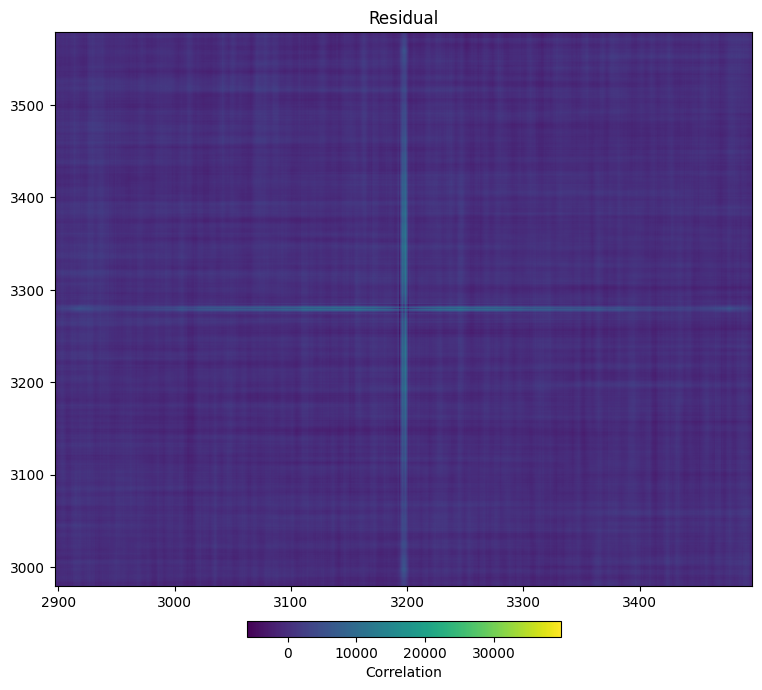

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
c0 = ax.imshow(composed_sutracted, aspect='auto')
fig.colorbar(c0, ax=ax, label="Correlation", location="bottom", pad=0.05, shrink=.45)
ax.set_title("Residual")
ax.set_xlim(max_subtracted[1] - 300, max_subtracted[1] + 300)
ax.set_ylim(max_subtracted[0] - 300, max_subtracted[0] + 300)
ax.autoscale(False)
plt.show()

## PSF filtering

In [92]:
def subtract(balanced):
    cog = center_of_gravity(balanced, *np.unravel_index(np.argmax(balanced), balanced.shape))

    sky_model = np.zeros(wfm.sky_shape)
    cog_i, cog_j = round(cog[0]), int(cog[1])
    decimal_j = cog[1] - cog_j
    sky_model[cog_i, cog_j] = (1 - decimal_j) * balanced[cog_i, cog_j]
    sky_model[cog_i, cog_j + 1] = decimal_j * balanced[cog_i, cog_j + 1]
    shadowgram = filter_psf(wfm, encode(wfm, sky_model)) * wfm.bulk
    norm_shadowgram = np.sum(~np.isclose(shadowgram, np.zeros_like(shadowgram)))
    model, _ =  decode(wfm, shadowgram / norm_shadowgram)

    sky_model[cog_i, cog_j] *= (balanced[cog_i, cog_j] / model[cog_i, cog_j])
    sky_model[cog_i, cog_j + 1] *= (balanced[cog_i, cog_j + 1] / model[cog_i, cog_j + 1])
    shadowgram = filter_psf(wfm, encode(wfm, sky_model)) * wfm.bulk
    model, _ =  decode(wfm, shadowgram / norm_shadowgram)
    return balanced - model, shadowgram / norm_shadowgram

In [93]:
balanced_1a_subtracted, shadowgram_1a = subtract(balanced_1a)

In [94]:
balanced_1b_subtracted, shadowgram_1b = subtract(balanced_1b)

In [95]:
composed_sutracted, composed_f = compose(balanced_1a_subtracted, balanced_1b_subtracted)
max_subtracted = np.unravel_index(np.argmax(composed), composed.shape)

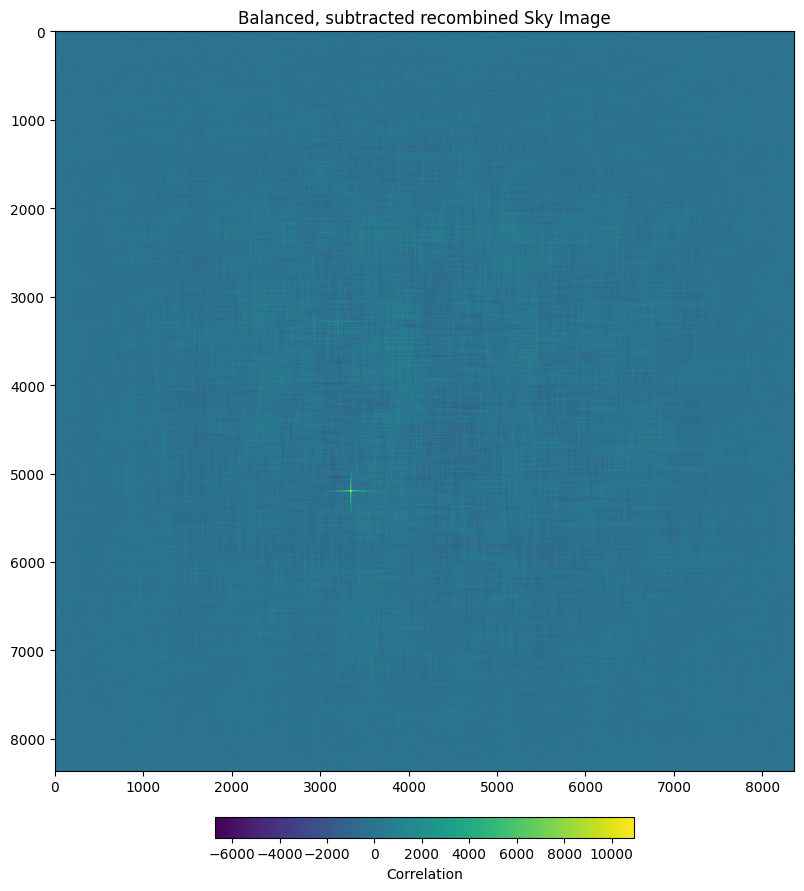

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
c0 = ax.imshow(composed_sutracted, vmax=-np.min(composed))
#ax.scatter(max_subtracted[1], max_subtracted[0], s=80, facecolors='none', edgecolors='k')
fig.colorbar(c0, ax=ax, label="Correlation", location="bottom", pad=0.05, shrink=.45)
ax.set_title("Balanced, subtracted recombined Sky Image")
plt.show()

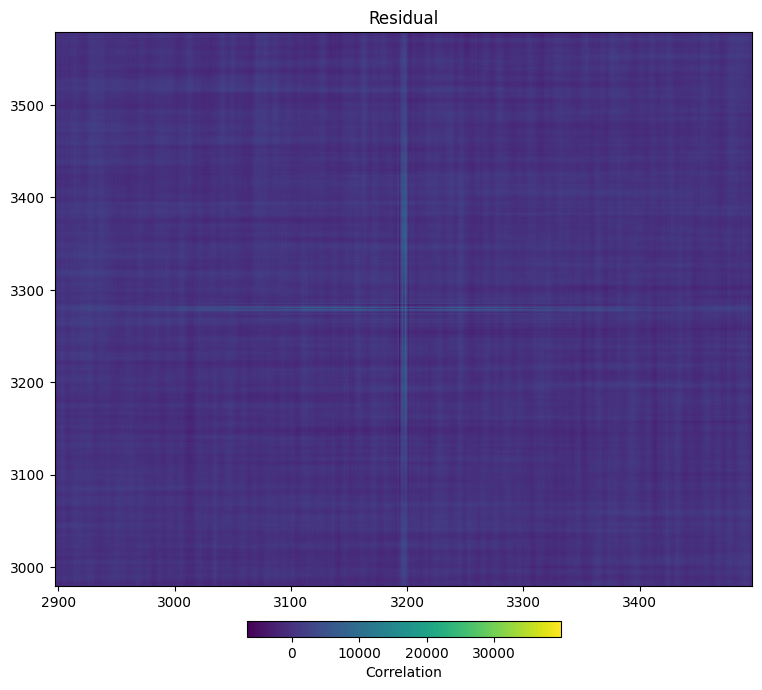

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
c0 = ax.imshow(composed_sutracted, aspect='auto')
fig.colorbar(c0, ax=ax, label="Correlation", location="bottom", pad=0.05, shrink=.45)
ax.set_title("Residual")
ax.set_xlim(max_subtracted[1] - 300, max_subtracted[1] + 300)
ax.set_ylim(max_subtracted[0] - 300, max_subtracted[0] + 300)
ax.autoscale(False)
plt.show()

In [98]:
max_composed

(np.int64(3279), np.int64(3197))

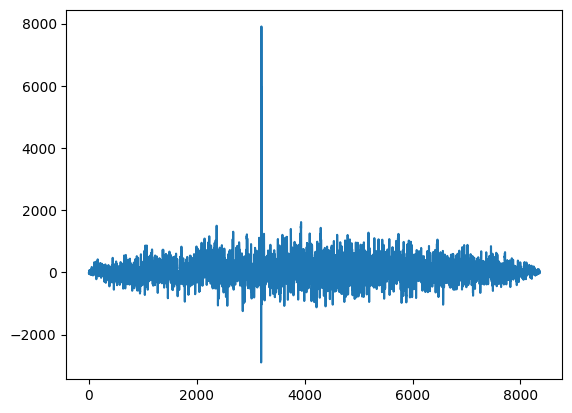

In [112]:
plt.plot(balanced_1a_subtracted[max_composed[0], :])